<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align ="center"></a>

<h1 align=center><font size = 5> SVM (Support Vector Machines)</font></h1>

En este cuaderno, utilizará SVM **(Support Vector Machines)(Máquinas de vectores de soporte)** para construir y entrenar un modelo utilizando registros de células humanas, y clasificar las células para determinar si las muestras son benignas o malignas.

SVM funciona asignando datos a un espacio de características de alta dimensión para que los puntos de datos se puedan clasificar, incluso cuando los datos no son separables linealmente. Se encuentra un separador entre las categorías, luego los datos se transforman de tal manera que el separador se pueda dibujar como un hiperplano. Después de esto, las características de los nuevos datos se pueden usar para predecir el grupo al que debe pertenecer un nuevo registro.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

###  Load the Cancer data // Cargue los datos del cáncer
El ejemplo se basa en un conjunto de datos que está disponible públicamente desde el Depósito de aprendizaje automático de UCI
(Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. El conjunto de datos consta de varios cientos de registros de muestras de células humanas, cada uno de los cuales contiene los valores de un conjunto de características de la célula. Los campos en cada registro son:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

Para los propósitos de este ejemplo, estamos utilizando un conjunto de datos que tiene un número relativamente pequeño de predictores en cada registro. Para descargar los datos, usaremos `!wget` para descargarlos de IBM Object Storage.
__¿Sabía que?__ Cuando se trata de Machine Learning, es probable que trabaje con grandes conjuntos de datos. Como empresa, ¿dónde puede alojar sus datos? IBM ofrece una oportunidad única para las empresas, con 10 Tb de IBM Cloud Object Storage:[Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)

In [ ]:
#Click here and press Shift+Enter
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

### Load Data From CSV File  

In [5]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


El campo ID contiene los identificadores del paciente. Las características de las muestras de células de cada paciente están contenidas en los campos Clump to Mit. Los valores se califican de 1 a 10, siendo 1 el más cercano a benigno.

El campo Clase contiene el diagnóstico, según lo confirmado por procedimientos médicos separados, en cuanto a si las muestras son benignas (valor = 2) o malignant (valor = 4).

Veamos la distribución de las clases según el grosor del grupo y la uniformidad del tamaño de la celda:


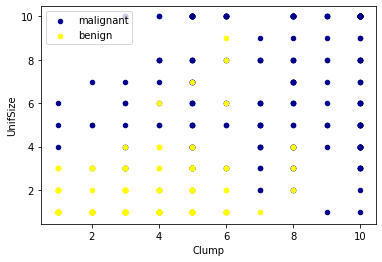

In [7]:
ax = cell_df[cell_df['Class'] == 4][0:500].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:500].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Data pre-processing and selection

Veamos primero los tipos de datos de columnas:

In [8]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Parece que la columna __BareNuc__ incluye algunos valores que no son numéricos. Podemos soltar esas filas:

In [9]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [10]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

Queremos que el modelo prediga el valor de Clase (es decir, benigno (= 2) o malignant (= 4)). Como este campo puede tener uno de los dos valores posibles, necesitamos cambiar su nivel de medición para reflejar esto.


In [11]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

Okay, we split our dataset into train and test set:

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


# Modeling (SVM with Scikit-learn)

El algoritmo SVM ofrece una selección de funciones del núcleo para realizar su procesamiento. Básicamente, el mapeo de datos en un espacio dimensional superior se llama **kernelling**. La función matemática utilizada para la transformación se conoce como la función del kernel y puede ser de diferentes tipos, como:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Cada una de estas funciones tiene sus características, sus pros y sus contras, y su ecuación, pero como no hay una manera fácil de saber qué función funciona mejor con un conjunto de datos dado, generalmente elegimos diferentes funciones y comparamos los resultados. Simplemente usemos el RBF (Radial Basis Function)  predeterminado para esta práctica de laboratorio.

In [13]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Después de ser ajustado, el modelo puede usarse para predecir nuevos valores:

In [14]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

## Evaluation

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


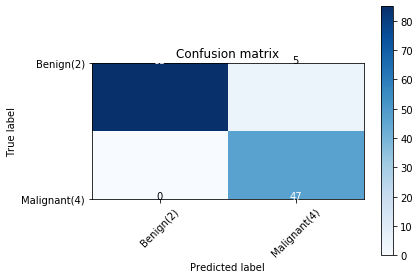

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

También puede usar fácilmente la biblioteca __f1_score__ fron sklearn:

In [19]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Lets try jaccard index for accuracy:
Probemos el índice jaccard para mayor precisión:

In [20]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

C:\Users\rodri\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9635036496350365

## Practice
¿Puedes reconstruir el modelo, pero esta vez con un __linear__ kernel?? Puede usar la opción __kernel = 'linear'__, cuando define el svm. ¿Cómo cambia la precisión con la nueva función del kernel?


In [21]:
# write your code here
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))



Avg F1-score: 0.9639
Jaccard score: 0.9635


C:\Users\rodri\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Double-click __here__ for the solution.

<!-- Your answer is below:
    
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))

-->

## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>

<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​